In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from data.data_reading import data_reading
from data.data_processing import data_processing

from ruspy.simulation.simulation import simulate
from ruspy.simulation.value_zero import calc_ev_0, discount_utility
from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import (
    lin_cost,
    cost_func,
    create_transition_matrix,
    calc_fixp,
    choice_prob
)
from scripts.worst_case_probs import calc_fixp_worst
import pickle as pkl
import glob

In [2]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 200 buses should be enough to gurantee convergence.
num_buses = 200
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 70000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize) + 1

In [3]:
dict_polcies = pkl.load(open("data/results.pkl", "rb"))
omega_range = np.linspace(0, 0.99, 100)
worst_evs = []
worst_trans_mats = []
for omega in omega_range:
    worst_evs += [dict_polcies[omega][0]]
    worst_trans_mats += [dict_polcies[omega][1]]

In [4]:
trans_mat_ml = worst_trans_mats[0]
ev_ml = worst_evs[0]
ev_worst = worst_evs[-1]

In [5]:
num_states = ev_ml.shape[0]
params = np.loadtxt("scripts/resources/rust_cost_params.txt")
p_ml = np.loadtxt("scripts/resources/rust_trans_probs.txt")
costs = cost_func(num_states, lin_cost, params)

In [6]:
choice_ml = choice_prob(ev_ml, costs, beta)
choice_worst = choice_prob(ev_worst, costs, beta)

[]

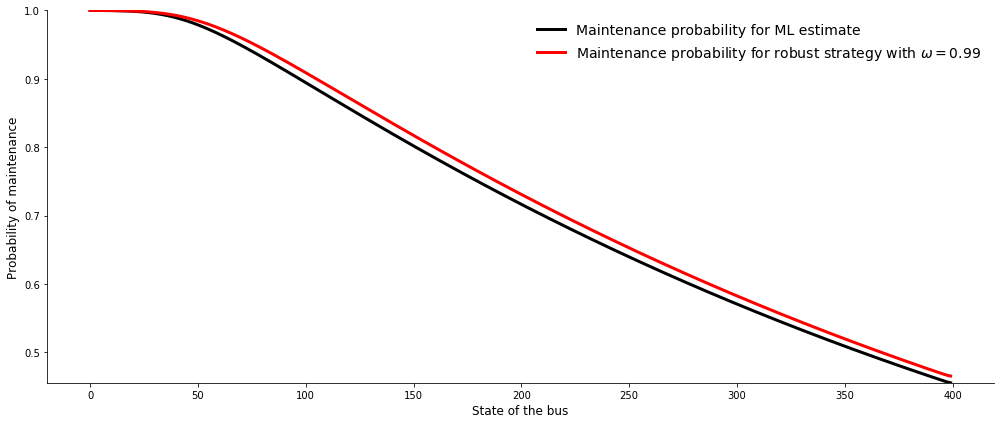

In [7]:
state_range = 400
y_0 = choice_ml[-1, 0]
y_1 = 1

states = range(state_range)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([y_0, y_1])
ax.set_ylabel(r"Probability of maintenance")
ax.set_xlabel(r"State of the bus")
ax.plot(states, choice_ml[:state_range, 0], color='k', label='Maintenance probability for ML estimate')
ax.plot(states, choice_worst[:state_range, 0], color='red', label='Maintenance probability for robust strategy with $\omega = 0.99$')


plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [10]:
dict_polcies_style = pkl.load(open("data/stylized/results.pkl", "rb"))

In [15]:
ev_ml_style = dict_polcies_2[0.0][0]
ev_worst_style = dict_polcies_2[0.95][0]

In [16]:
num_states_stylestyle = ev_ml_style.shape[0]
params_style = np.array([25, 150])
costs_style = cost_func(num_states_style, lin_cost, params_style)

In [17]:
choice_ml_style = choice_prob(ev_ml_style, costs_style, beta)
choice_worst_style = choice_prob(ev_worst_style, costs_style, beta)

[]

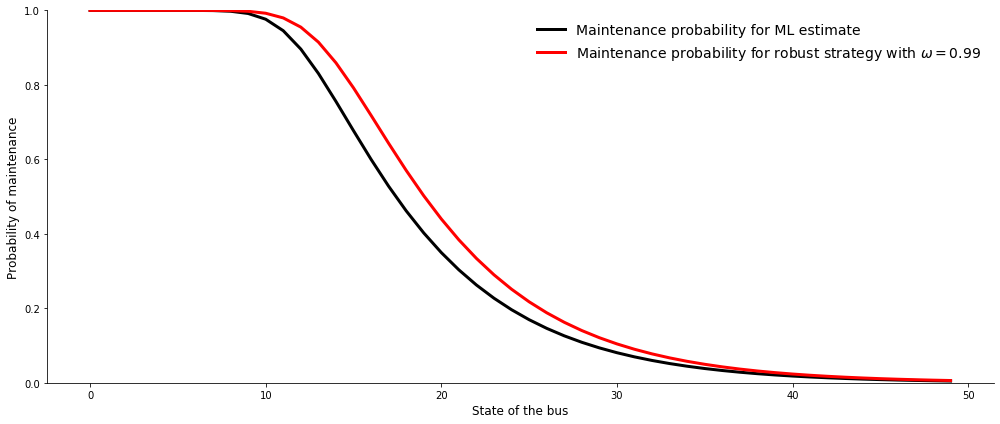

In [19]:
state_range = 50
y_0 = 0
y_1 = 1

states = range(state_range)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([y_0, y_1])
ax.set_ylabel(r"Probability of maintenance")
ax.set_xlabel(r"State of the bus")
ax.plot(states, choice_ml_style[:state_range, 0], color='k', label='Maintenance probability for ML estimate')
ax.plot(states, choice_worst_style[:state_range, 0], color='red', label='Maintenance probability for robust strategy with $\omega = 0.99$')


plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [20]:
means_robust_strat = np.array([])
for file in sorted(glob.glob("data/df_thres/df*")):
    df = pkl.load(open(file,"rb"))
    means_robust_strat = np.append(means_robust_strat, np.mean(df[df["decision"] == 1]["state"]))

In [10]:
means_discrete = np.around(means_robust_strat)

In [11]:
omega_range = np.linspace(0, 0.99, 100)[::9]

In [12]:
means_ml = np.full(len(omega_range), np.around(means_robust_strat[0]))

In [13]:
omega_sections = []
state_sections = []
for j, i in enumerate(np.unique(means_discrete)):
    where = means_discrete == i
    if j == 0:
        med_val = (np.max(omega_range[where]) + np.min(omega_range[~where])) / 2
        omega_sections += [np.append(omega_range[where], med_val)]
        state_sections += [np.append(means_discrete[where], i)]
    elif j == (len(np.unique(means_discrete)) - 1):
        med_val = (np.min(omega_range[where]) + np.max(omega_range[~where])) / 2
        omega_sections += [np.array([med_val] + omega_range[where].tolist())]
        state_sections += [np.array([i] + means_discrete[where].tolist())]
    else:
        med_val_low = (np.min(omega_range[where]) + np.max(omega_sections[-1][:-1])) / 2
        med_val_high = (np.max(omega_range[where]) + np.min(omega_range[means_discrete == i + 1])) / 2
        omega_sections += [np.array([med_val_low] + omega_range[where].tolist() + [med_val_high])]
        state_sections += [np.array([i] + means_discrete[where].tolist() + [i])]

[]

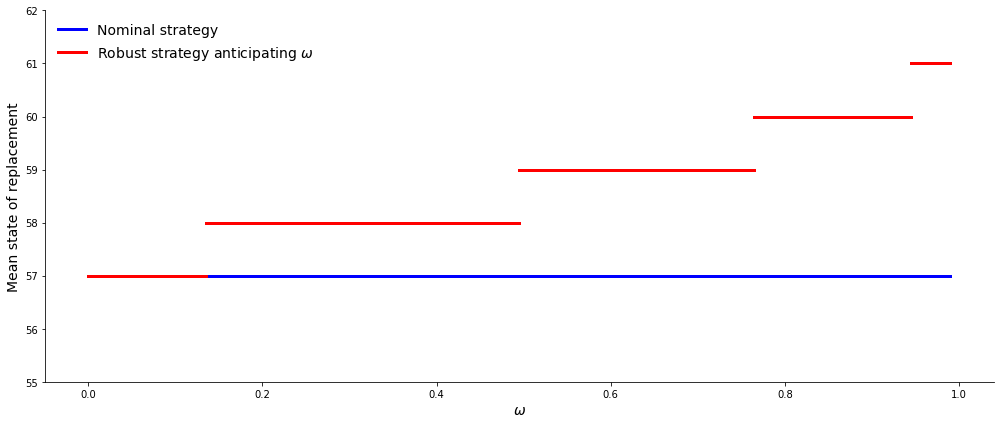

In [14]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([55, 62])
ax.set_ylabel(r"Mean state of replacement",fontsize=14)
ax.set_xlabel(r"$\omega$", fontsize=14)
ax.plot(omega_range, means_ml, color='blue', label='Nominal strategy')
for j, i in enumerate(omega_sections[:-1]):
    ax.plot(i, state_sections[j], color='red')
ax.plot(omega_sections[-1], state_sections[-1], color='red', label="Robust strategy anticipating $\omega$")


plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [40]:
df_trans_99_ev_ml = pkl.load(open("data/df_trans_99_ev_0.0.pkl", "rb"))
df_trans_99_ev_99 = pkl.load(open("data/df_trans_99_ev_0.99.pkl", "rb"))

In [30]:
# Calculate the expected value at time zero
v_exp_ml = np.full(num_points + 1, calc_ev_0(df_trans_99_ev_ml, ev_ml))
v_exp_worst = np.full(num_points + 1, calc_ev_0(df_trans_99_ev_ml, ev_worst))
# Calculate the value at time 0 by discounting the utility
v_disc_ml = discount_utility(df_trans_99_ev_ml, gridsize, beta)
v_disc_99 = discount_utility(df_trans_99_ev_99, gridsize, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods + gridsize, gridsize)

[]

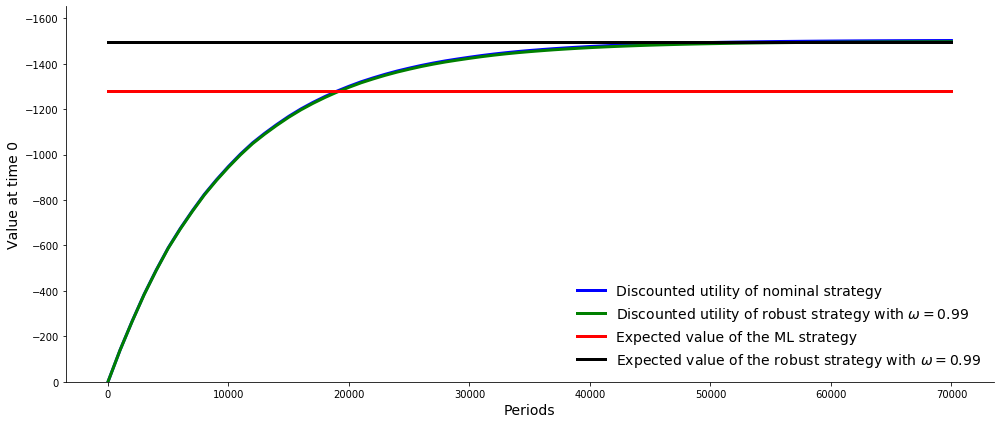

In [10]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0, 1.1 * v_disc_ml[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=14)
ax.set_xlabel(r"Periods", fontsize=14)
ax.plot(periods, v_disc_ml, color='blue', label='Discounted utility of nominal strategy')
ax.plot(periods, v_disc_99, color='green', label='Discounted utility of robust strategy with $\omega = 0.99$')
ax.plot(periods, v_exp_ml, color='red', label='Expected value of the ML strategy')
ax.plot(periods, v_exp_worst, color='k', label='Expected value of the robust strategy with $\omega = 0.99$')



plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [4]:
dict_policies_fine = pkl.load(open("data/fine_large/results.pkl", "rb"))

In [65]:
dict_scale = pkl.load(open("scripts/results.pkl", "rb"))

In [71]:
ev_scale_ml = dict_scale[0.0][0]
ev_scale_95 = dict_scale[0.95][0]
trans_scale = dict_scale[0.95][1]
ev_ml_fine = dict_policies_fine[0.0][0]
ev_worst_fine = dict_policies_fine[0.95][0]
trans_mat_95 = dict_policies_fine[0.95][1]
trans_mat_ml = dict_policies_fine[0.0][1]

ValueError: operands could not be broadcast together with shapes (600,600) (2,) 

In [70]:
ev_scale_95 - ev_worst_fine[:600]

array([6.88833570e-05, 6.88394578e-05, 6.88763573e-05, 6.89481078e-05,
       6.89920685e-05, 6.89092044e-05, 6.89415226e-05, 6.89705425e-05,
       6.89322935e-05, 6.89829519e-05, 6.88568618e-05, 6.89869553e-05,
       6.90441871e-05, 6.89564545e-05, 6.89070891e-05, 6.88645578e-05,
       6.88973146e-05, 6.88238788e-05, 6.88587716e-05, 6.87639315e-05,
       6.87879344e-05, 6.90004183e-05, 6.86071246e-05, 6.87635547e-05,
       6.87145082e-05, 6.88108673e-05, 6.88761356e-05, 6.89386452e-05,
       6.89479216e-05, 6.89773988e-05, 6.88598705e-05, 6.88226401e-05,
       6.89188530e-05, 6.89133465e-05, 6.88561540e-05, 6.88992418e-05,
       6.87003912e-05, 6.87015965e-05, 6.89464787e-05, 6.90810584e-05,
       6.88771920e-05, 6.88058994e-05, 6.89815856e-05, 6.89425692e-05,
       6.87916036e-05, 6.88362297e-05, 6.87749623e-05, 6.88688101e-05,
       6.87903475e-05, 6.87343843e-05, 6.86420890e-05, 6.87276060e-05,
       6.87870715e-05, 6.88100483e-05, 6.87541663e-05, 6.88692312e-05,
      

In [63]:
np.exp(-200)

1.3838965267367376e-87

In [68]:
for i in range(ev_ml_fine.shape[0]):
    print(np.abs(ev_scale_ml[i] - ev_scale_ml[0]), np.abs(ev_scale_95[i] - ev_scale_95[0]), i)

0.0 0.0 0
0.10272388762177798 0.08161535603562697 1
0.2045352063773862 0.16267509327281005 2
0.3054342676491615 0.24317943591790936 3
0.4054214159880303 0.323128397434175 4
0.5044970314634156 0.40252231301155916 5
0.6026615321288773 0.48136105348203273 6
0.6999153766018935 0.5596449991912777 7
0.7962590667639233 0.6373743171427577 8
0.8916931505709726 0.7145490305335898 9
0.9862182249873968 0.7911696412932088 10
1.0798349390277053 0.8672359759361825 11
1.172543996913646 0.9427485038668237 12
1.2643461613370164 1.017707440063532 13
1.3552422568329803 1.09211316367373 14
1.4452331732497896 1.1659658142179978 15
1.5343198693144586 1.2392657038824382 16
1.6225033762893872 1.3120132149247183 17
1.7097848017097022 1.3842086699673928 18
1.796165333195404 1.4558524682238385 19
1.8816462423280882 1.5269449004813396 20
1.9662288885831458 1.5974863504934547 21
2.049914723307438 1.6674776422319155 22
2.1327052937281223 1.736918680537201 23
2.214602246983759 1.805810408610796 24
2.295607334161332 1

IndexError: index 600 is out of bounds for axis 0 with size 600

In [6]:
df_fine_trans_95_ev_ml = pkl.load(open("data/fine_large/df_fl_trans_95_ev_0.0.pkl", "rb"))
df_fine_trans_95_ev_95 = pkl.load(open("data/fine_large/df_fl_trans_95_ev_0.95.pkl", "rb"))

In [56]:
np.quantile(df_fine_trans_95_ev_ml[df_fine_trans_95_ev_ml["decision"] == 1]["state"], 0.3)

109.0

In [57]:
np.quantile(df_fine_trans_95_ev_95[df_fine_trans_95_ev_95["decision"] == 1]["state"], 0.3)

126.0

In [32]:
df_fine_trans_95_ev_ml.state.max()

310

In [10]:
df = df_fine_trans_95_ev_ml[["Bus_ID", "state", "decision"]]

In [11]:
from ruspy.estimation.estimation_transitions import estimate_transitions

In [13]:
res_trans = estimate_transitions(df)

In [15]:
trans_mat = res_trans["state_count"]

In [21]:
trans_mat_95[0, 0:6]

array([0.01680024, 0.27623745, 0.50461506, 0.12153919, 0.02210677,
       0.05870128])

In [49]:
for i in range(trans_mat.shape[0]):
     print(Kullback_Leibler(trans_mat_95[i, i: i + 6], trans_mat_ml[i, i: i + 6]))

0.5535253186570703
0.5535249128190702
0.5535245807064799
0.5535253265934937
0.5535243416833778
0.5535247136571088
0.5535244526756371
0.553524527298134
0.5535245160225817
0.5535248078920609
0.553524852407316
0.5535242318778844
0.5535244864541516
0.553524625818856
0.5535253371278843
0.5535250077078071
0.5535251816990442
0.5535237792131029
0.5535251151812826
0.5535249658197394
0.5535243808647439
0.5535260818795007
0.553522702724511
0.5535243823632128
0.5535239331899037
0.5535243287583433
0.5535245979860299
0.5535250701967023
0.5535239318771921
0.5535247529467731
0.5535244615707758
0.5535234115612886
0.5535244792756198
0.5535250079501741
0.5535239396730876
0.5535247376702239
0.553524560721846
0.553523962525771
0.5535245934748296
0.5535259910315347
0.5535236607463263
0.5535222699249092
0.5535269768367378
0.5535253933778952
0.553524970073038
0.5535248355376761
0.5535244917791506
0.553525532317422
0.5535253222023251
0.55352495120499
0.5535223351743246
0.5535244236128778
0.5535248506354644
0.5

In [48]:
chi2.ppf(0.95, 5) / (2 * 10)

0.5535248846758176

In [23]:
trans_mat_ml[0, 0:6]

array([0.1167288 , 0.55941286, 0.30032619, 0.02143523, 0.00116496,
       0.00093197])

In [36]:
# Calculate the expected value at time zero
v_exp_ml_fine = np.full(num_points, calc_ev_0(df_fine_trans_95_ev_ml, ev_ml_fine))
v_exp_worst_fine = np.full(num_points, calc_ev_0(df_fine_trans_95_ev_ml, ev_worst_fine))
# Calculate the value at time 0 by discounting the utility
v_disc_ml_fine = discount_utility(df_fine_trans_95_ev_ml, gridsize, beta)
v_fine_disc_95 = discount_utility(df_fine_trans_95_ev_95, gridsize, beta)
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods + gridsize, gridsize)

In [37]:
v_disc_ml_fine[-1] - v_fine_disc_95[-1]

-17.03256099700411

[]

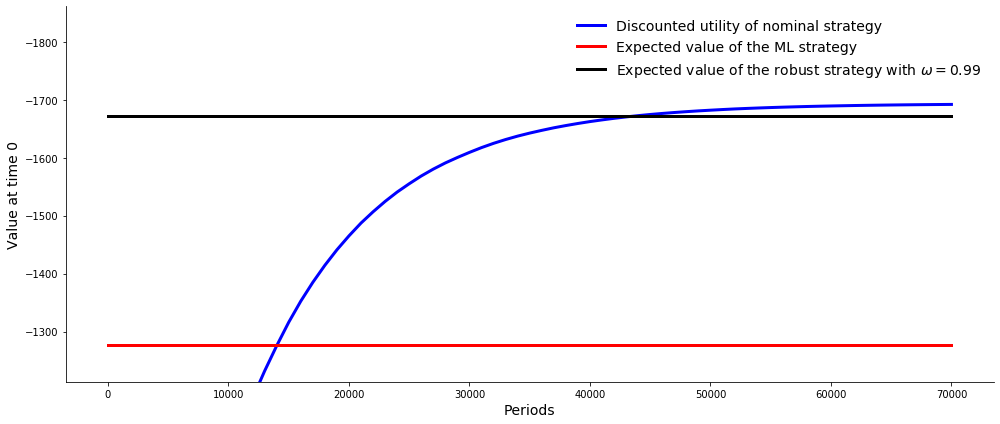

In [40]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax.set_ylim([0.95 * v_exp_ml_fine[0], 1.1 * v_disc_ml_fine[-1]])
ax.set_ylabel(r"Value at time 0",fontsize=14)
ax.set_xlabel(r"Periods", fontsize=14)
ax.plot(periods, v_disc_ml_fine, color='blue', label='Discounted utility of nominal strategy')
# 'ax.plot(periods, v_fine_disc_95, color='green', label='Discounted utility of robust strategy with $\omega = 0.99$')
ax.plot(periods, v_exp_ml_fine, color='red', label='Expected value of the ML strategy')
ax.plot(periods, v_exp_worst_fine, color='k', label='Expected value of the robust strategy with $\omega = 0.99$')



plt.legend()
ax.legend(fontsize=14)
plt.tight_layout()

plt.plot()

In [46]:
def Kullback_Leibler(p, p_ml):
    """
    This function calculate the Kullback Leibler Divergence of p and p_ml.
    :param p:
    :param p_ml:
    :return:
    """
    return np.sum(np.multiply(p, np.log(np.divide(p, p_ml))))